In [4]:
import dataclasses

import corner
import emcee
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize, stats

from cr_knee_fit.cr_model import (
    CosmicRaysModel,
    CosmicRaysModelConfig,
    RigidityBreak,
    SharedPowerLaw,
)
from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import make_loglikelihood, make_logposterior
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.plotting import plot_credible_band
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts
from cr_knee_fit.types_ import Experiment, Primary
from cr_knee_fit.utils import add_log_margin

In [6]:
EXPERIMENTS = [e for e in Experiment if e.available_primaries()]

config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        components=[
            [Primary.H],
            [Primary.He],
            sorted(p for p in Primary if p not in {Primary.H, Primary.He}),
        ],
        n_breaks=2,
        rescale_all_particle=False,
    ),
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

fit_data = FitData.load(
    experiments_detailed=[e for e in EXPERIMENTS if e.available_primaries()],
    experiments_all_particle=[e for e in EXPERIMENTS if not e.available_primaries()],
    primaries=config.cr_model_config.primaries,
    R_bounds=(7e2, 1e8),
)

In [7]:
def initial_guess_model(config: ModelConfig) -> Model:
    return Model(
        cr_model=CosmicRaysModel(
            base_spectra=[
                (
                    SharedPowerLaw(
                        lgI_per_primary={
                            primary: stats.norm.rvs(loc=-4, scale=0.5) - 2.6 * np.log10(primary.Z)
                            for primary in component
                        },
                        alpha=stats.norm.rvs(loc=2.7, scale=0.1),
                    )
                )
                for component in config.cr_model_config.components
            ],
            breaks=[
                # dampe softening
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=4.2, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(5), scale=0.01),
                ),
                # grapes hardening
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=5.3, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=-0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(10), scale=0.01),
                ),
                # knee
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=6.5, scale=0.2),
                    d_alpha=stats.norm.rvs(loc=0.5, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(5), scale=0.01),
                ),
            ][: config.cr_model_config.n_breaks],
            all_particle_lg_shift=stats.norm.rvs(scale=0.2),
        ),
        energy_shifts=ExperimentEnergyScaleShifts(
            lg_shifts={exp: stats.norm.rvs(loc=0, scale=0.01) for exp in config.shifted_experiments}
        ),
    )

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 46.440753962608376
             x: [-4.102e+00  2.617e+00 ...  1.166e+00  1.790e-01]
           nit: 3717
          nfev: 4831
 final_simplex: (array([[-4.102e+00,  2.617e+00, ...,  1.166e+00,
                         1.790e-01],
                       [-4.102e+00,  2.617e+00, ...,  1.166e+00,
                         1.790e-01],
                       ...,
                       [-4.102e+00,  2.617e+00, ...,  1.166e+00,
                         1.790e-01],
                       [-4.102e+00,  2.617e+00, ...,  1.166e+00,
                         1.790e-01]]), array([ 4.644e+01,  4.644e+01, ...,  4.644e+01,  4.644e+01]))
  1.                          lgI_{H} = -4.10e+00
  2.                        alpha_{H} = 2.62e+00
  3.                         lgI_{He} = -4.96e+00
  4.                       alpha_{He} = 2.55e+00
  5.                          lgI_{C} = -6.96e+00
  6.           

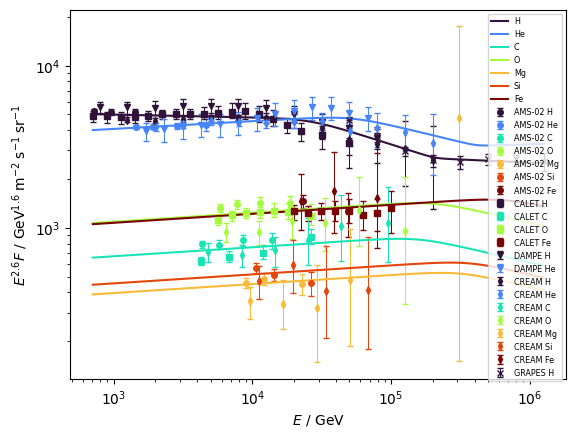

In [8]:
pre_optimization_config = dataclasses.replace(config, shifted_experiments={})
loglike = make_loglikelihood(fit_data, pre_optimization_config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=initial_guess_model(pre_optimization_config).pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
)
print(res)

mle_model = Model.unpack(res.x, layout_info=pre_optimization_config)
mle_model.plot(fit_data, scale=2.6)
mle_model.print_params()

In [10]:
n_steps = 10_000
n_walkers = 128
n_dim = initial_guess_model(config).ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

100%|██████████| 10000/10000 [18:30<00:00,  9.01it/s]


Acceptance fraction: 0.27557187499999997


The chain is shorter than 50 times the integrated autocorrelation time for 12 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 92.1726802  328.55712755  68.10685415 279.16765695  33.64601632
  82.19521205 109.46456004  66.98118693 108.69400463 334.58005396
 350.14291566 449.34681483 290.68715609 416.13936765 413.31314515
 284.27726661 125.79394631 277.99711534 359.35303965 335.48668119
 140.16485013]


tau = array([ 92.1726802 , 328.55712755,  68.10685415, 279.16765695,
        33.64601632,  82.19521205, 109.46456004,  66.98118693,
       108.69400463, 334.58005396, 350.14291566, 449.34681483,
       290.68715609, 416.13936765, 413.31314515, 284.27726661,
       125.79394631, 277.99711534, 359.35303965, 335.48668119,
       140.16485013])
burn_in = 2245 thin = 898
MCMC sample ready, shape: (1024, 21)


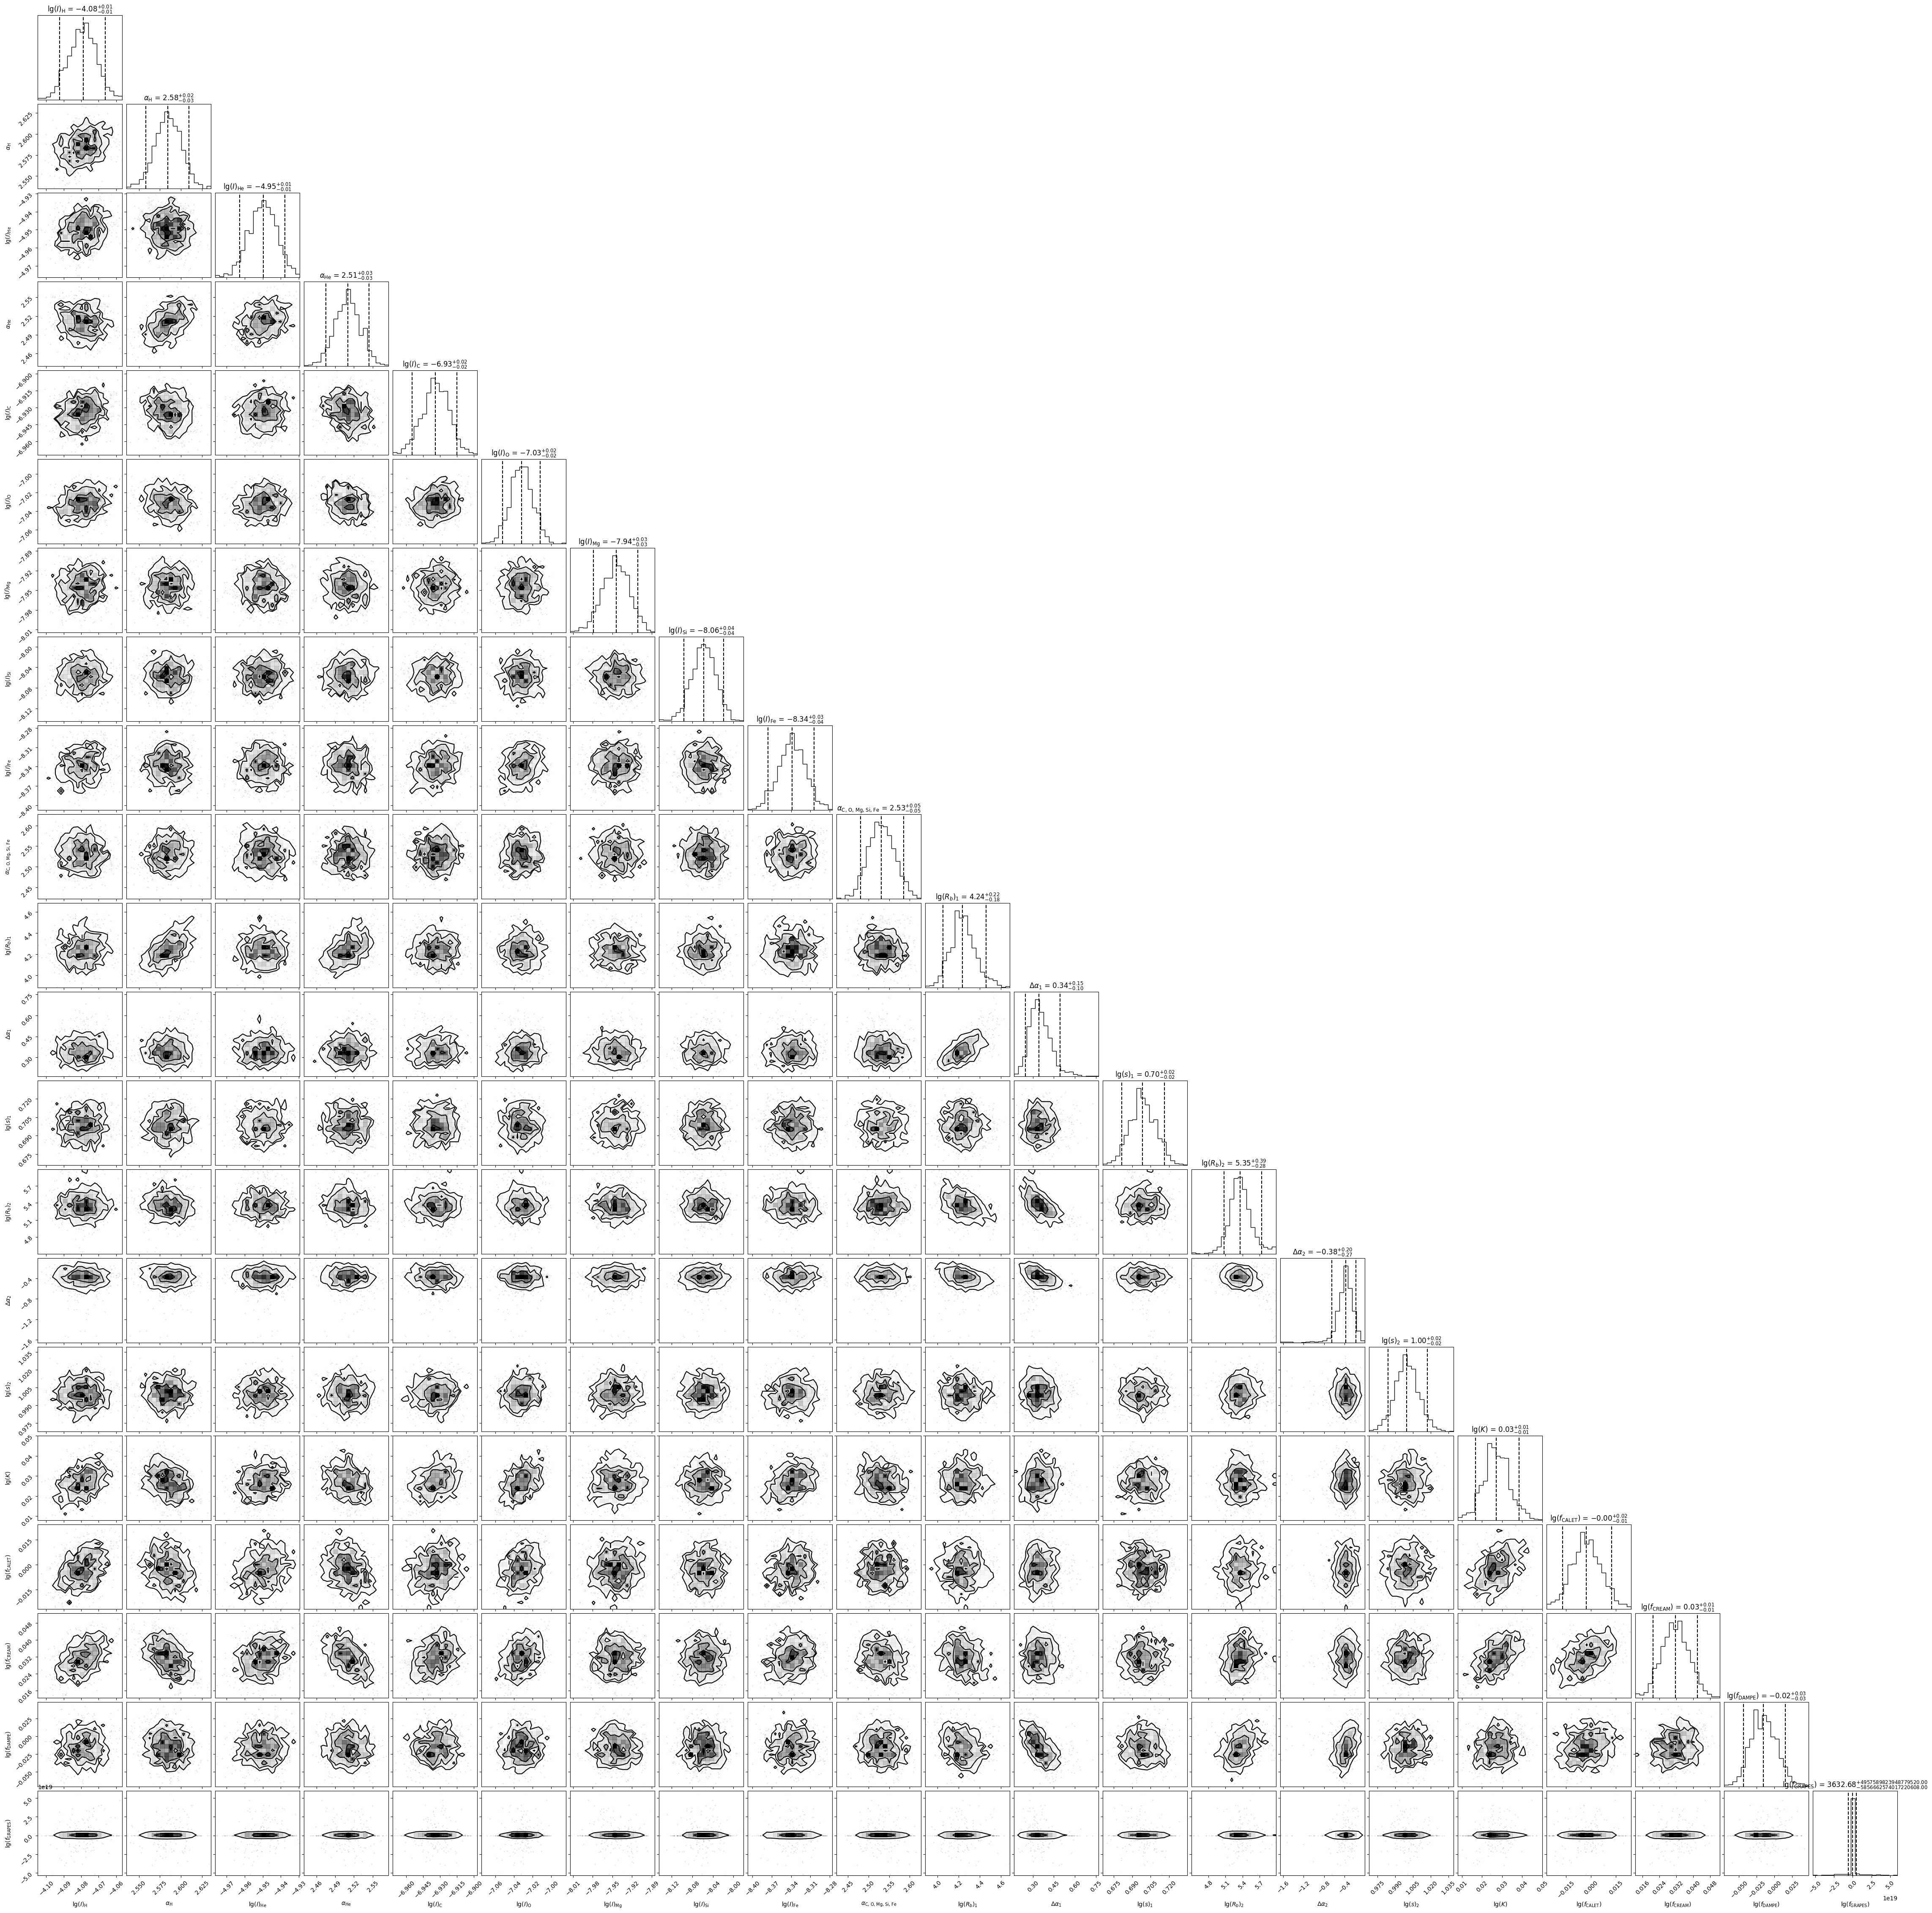

In [11]:
sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in initial_guess_model(config).labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    quantiles=[0.05, 0.5, 0.95],
)

  1.                          lgI_{H} = -4.08e+00
  2.                        alpha_{H} = 2.58e+00
  3.                         lgI_{He} = -4.95e+00
  4.                       alpha_{He} = 2.51e+00
  5.                          lgI_{C} = -6.93e+00
  6.                          lgI_{O} = -7.03e+00
  7.                         lgI_{Mg} = -7.94e+00
  8.                         lgI_{Si} = -8.06e+00
  9.                         lgI_{Fe} = -8.34e+00
 10.         alpha_{C, O, Mg, Si, Fe} = 2.53e+00
 11.                        lg(R_b)_1 = 4.24e+00
 12.                        d_alpha_1 = 3.43e-01
 13.                          lg(s)_1 = 6.99e-01
 14.                        lg(R_b)_2 = 5.35e+00
 15.                        d_alpha_2 = -3.77e-01
 16.                          lg(s)_2 = 1.00e+00
 17.                      lg(f_CALET) = 2.70e-02
 18.                      lg(f_CREAM) = 3.17e-02
 19.                      lg(f_DAMPE) = -2.71e-03
 20.                     lg(f_GRAPES) = -1.56e-02


(np.float64(334.8609921184278), np.float64(2663278.2587127783))

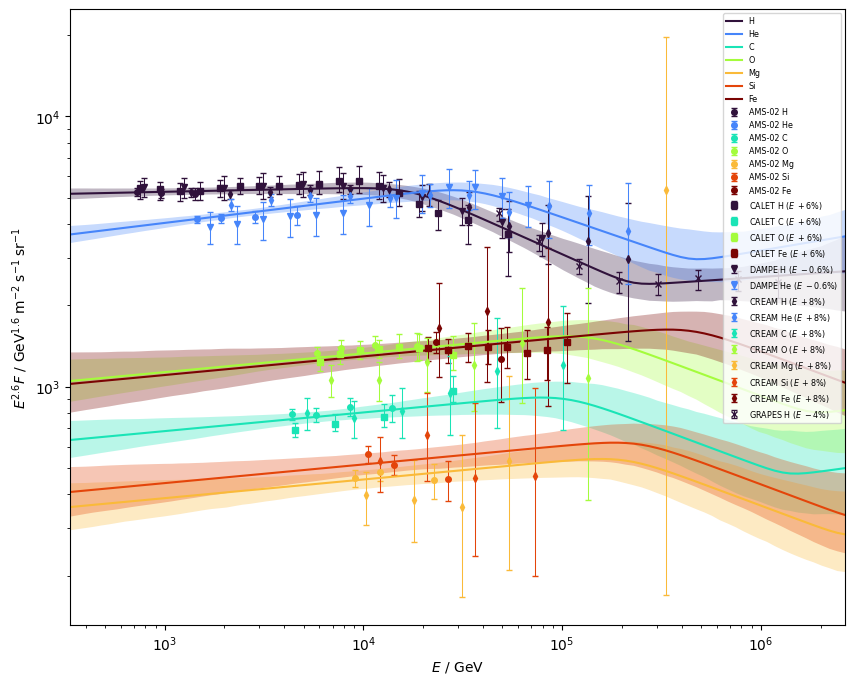

In [18]:
scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)
median_model.print_params()

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, spectrum in data_by_particle.items():
        spectrum.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(
            scale=scale, ax=ax
        )

for exp, spectrum in fit_data.all_particle_spectra.items():
    spectrum.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = median_model.cr_model.layout_info().primaries
Emin, Emax = add_log_margin(fit_data.E_min(), fit_data.E_max())
median_model.cr_model.plot(Emin, Emax, scale=scale, axes=ax)

for p in primaries:
    plot_credible_band(
        ax,
        scale=scale,
        model_sample=model_sample,
        observable=lambda model, E: model.cr_model.compute(E, p),
        color=p.color,
        E_bounds=(Emin, Emax),
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(Emin, Emax)